<a href="https://colab.research.google.com/github/Ezan/VTransUNet/blob/main/ViTransUnet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
root_path = '/content/drive/MyDrive/Colab Notebooks/U-Net/'
os.chdir(root_path)

In [3]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.1 MB/s 


In [4]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.metrics import BinaryIoU, MeanIoU
from keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow_addons as tfa
import keras.backend as K


In [5]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __crop__(self, img, x1, x2, y1, y2):
      cropped_image = img[x1:x2, y1:y2]
      return cropped_image

    def __contrast__(self, img):
      lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
      l_channel, a, b = cv2.split(lab)

      # Applying CLAHE to L-channel
      # feel free to try different values for the limit and grid size:
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      cl = clahe.apply(l_channel)

      # merge the CLAHE enhanced L-channel with the a and b channel
      limg = cv2.merge((cl,a,b))

      # Converting image from LAB Color model to BGR color spcae
      enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
      return enhanced_img


    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        #image = self.__contrast__(image)
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #256x256
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
# CONFIG
learning_rate = 0.0001
weight_decay = 0.0001
num_epochs = 100
image_size = 256  # We'll resize input images to this size
input_shape = (image_size, image_size, 3)
patch_size = 16  # Size of the patches to be extract from the input images [32, 16, 8]
num_patches = (image_size // patch_size) ** 2
projection_dim = 768  # 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
hidden_size=768


In [7]:
train_path = "train"
val_path = "test"

## Training Ids
train_ids = next(os.walk(train_path))[1]
# valid_ids = next(os.walk(val_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids#[val_data_size:]

In [8]:
print(len(train_ids))
print(len(valid_ids))

57
10


In [5]:
sample_gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x_sample, y_sample = sample_gen.__getitem__(0)
print(x_sample.shape, y_sample.shape)

NameError: ignored

In [10]:
random_sample = random.choices(os.listdir(train_path), k=3)
print(random_sample)

['310Cop10mM2ND4', '310Cop10mM11', '310Cop5mM9']


<ipython-input-11-f676912537e0>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 2, 1)
<ipython-input-11-f676912537e0>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 2, 2)


(9, 256, 256, 3)
(9, 256, 256, 1)


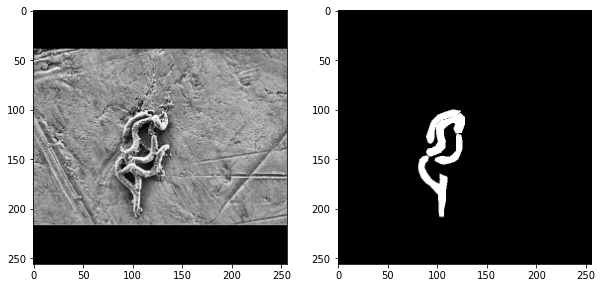

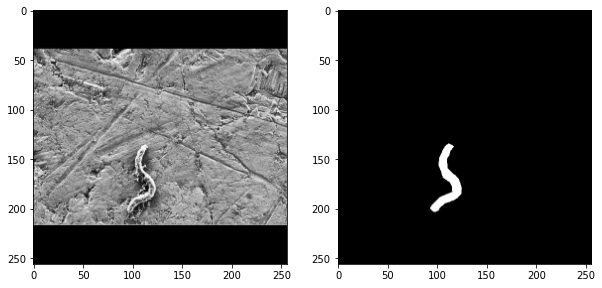

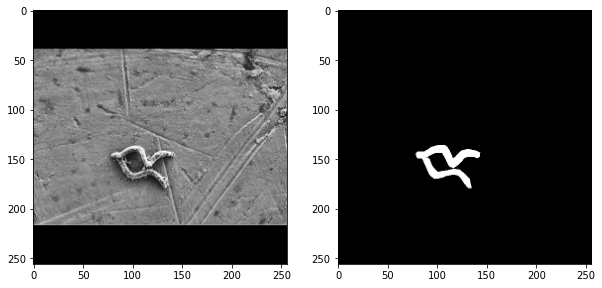

In [11]:
from re import I
for i, filename  in enumerate(random_sample):
  x, y = sample_gen.__getitem__(i)
  fig = plt.figure(figsize=(10,10))
  # fig.subplots_adjust(hspace=0.4, wspace=0.4)
  # fig.set_size_inches(20, 20)
  # fig.subplots(5,2)
  for j in range(2):
    ax = fig.add_subplot(1, 2, 1) 
    ax.imshow(np.reshape(x[j], (image_size, image_size,3)), cmap="gray")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")

print(x.shape)
print(y.shape)

In [61]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [62]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_sample[np.random.choice(range(x_sample.shape[0]))]
plt.imshow(np.reshape(image, (image_size, image_size,3)), cmap="gray")
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(resized_image.shape)
print(patches.shape)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img, cmap="gray")
    plt.axis("off")

NameError: ignored

<Figure size 288x288 with 0 Axes>

In [64]:
class PatchEncoder(layers.Layer):
    def __init__(self, *args, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(*args, **kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [16]:
initializer = tf.keras.initializers.GlorotUniform(seed=20)

In [65]:

class TransformerBlock(layers.Layer):
  def __init__(self, *args, num_heads, mlp_dim, dropout, trainable=True, **kwargs):
    super().__init__(*args, **kwargs)
    self.num_heads = num_heads
    self.mlp_dim = mlp_dim 
    self.dropout = dropout

  def build(self, input_shape):
    self.attention_output = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=self.dropout, name="MSA_1")
    self.mlp_block = keras.Sequential([
        layers.Dense(self.mlp_dim, activation=tf.nn.gelu, name=f"{self.name}/Dense_0"),
        layers.Dropout(self.dropout),
        layers.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
        layers.Dropout(self.dropout)
    ])
    self.layernorm1 = layers.LayerNormalization(
          epsilon=1e-6, name="LayerNorm_0"
      )
    self.layernorm2 = layers.LayerNormalization(
        epsilon=1e-6, name="LayerNorm_2"
    )
    self.dropout = layers.Dropout(self.dropout)

  def call(self, inputs, training):
    x = self.layernorm1(inputs)
    x = self.attention_output(x, x)
    x = self.dropout(x, training=training)
    x = x + inputs
    y = self.layernorm2(x)
    y = self.mlp_block(y)
    return x + y
    


In [66]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(c)
    return c

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(concat)
    c = BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="tanh", kernel_initializer=initializer)(c)
    return c

In [67]:
def unet():
    f = [16,32,64,128,256,512, 1024]
    inputs = keras.layers.Input((image_size, image_size, 3)) # Try 256*256*3
    
    p0 = inputs
    aug = data_augmentation(p0)
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    # c5, p5 = down_block(p4, f[4]) #16->8
    # c6, p6 = down_block(p5, f[5]) #16->8
    
    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #64 -> 128
    u2 = up_block(u1, c3, f[2]) #64 -> 128
    u3 = up_block(u2, c2, f[1]) #8 -> 16
    u4 = up_block(u3, c1, f[0]) #16 -> 32
    # u5 = up_block(u4, c2, f[1]) #32 -> 64
    # u6 = up_block(u5, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid", kernel_initializer=initializer)(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [68]:
def trans_unet():
    # filters
    f = [16,32,64,128,256,512]
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    # Create patches.
    patches = Patches(patch_size)(p4)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim, name="Transformer/posembed_input")(patches)
    encoded_patches = layers.Dropout(0.1)(encoded_patches)
    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        encoded_patches = TransformerBlock(num_heads=num_heads, mlp_dim=3072, dropout=0.1, name=f"Transformer/encoderblock_{i}")(encoded_patches)

    # Create a [batch_size, projection_dim] tensor.
    y = layers.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(encoded_patches)
    n_patch_sqrt = int(np.math.sqrt(y.shape[1]))

    y = layers.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)
    
    # Decoder cup
    d1 = up_block(y, c4, f[3]) #64 -> 128
    d2 = up_block(d1, c3, f[2]) #64 -> 128
    d3 = up_block(d2, c2, f[1]) #8 -> 16
    d4 = up_block(d3, c1, f[0]) #16 -> 32

    logits = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid", kernel_initializer=initializer)(d4)
    # # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [69]:
opt = Adam(learning_rate=learning_rate)
loss_function = 'binary_crossentropy' # try binary_crossentropy

In [70]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [71]:
#UNet model compile
unet_model = unet()
unet_model.compile(optimizer=opt, 
              loss=loss_function, 
              metrics=[
                dice_coef,
                # keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
                MeanIoU(num_classes=2),
              ],)
unet_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_144 (Conv2D)            (None, 256, 256, 16  448         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_145 (Conv2D)            (None, 256, 256, 16  2320        ['conv2d_144[0][0]']             
                                )                                                           

In [74]:
vit_unet_model = trans_unet()
vit_unet_model.compile(
    optimizer=opt,
    loss=loss_function,
    metrics=[
        dice_coef,
        # keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        MeanIoU(num_classes=2)
    ],
)
vit_unet_model.summary()

ValueError: ignored

In [41]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = max(len(valid_ids)//batch_size,1)

print(train_steps)


6


In [42]:
unet_hist = unet_model.fit(
    train_gen, 
    validation_data=valid_gen, 
    steps_per_epoch=train_steps, 
    validation_steps=valid_steps, 
    epochs=100)

Epoch 1/100
6/6 [==============================] - 4s 363ms/step - loss: 0.7021 - dice_coef: 0.0457 - mean_io_u_2: 0.4912 - val_loss: 0.7063 - val_dice_coef: 0.0383 - val_mean_io_u_2: 0.4909
Epoch 2/100
6/6 [==============================] - 0s 76ms/step - loss: 0.4478 - dice_coef: 0.0340 - mean_io_u_2: 0.4937 - val_loss: 0.6468 - val_dice_coef: 0.0435 - val_mean_io_u_2: 0.4886
Epoch 3/100
6/6 [==============================] - 0s 77ms/step - loss: 0.3383 - dice_coef: 0.0291 - mean_io_u_2: 0.4932 - val_loss: 0.5584 - val_dice_coef: 0.0393 - val_mean_io_u_2: 0.4886
Epoch 4/100
6/6 [==============================] - 0s 76ms/step - loss: 0.2693 - dice_coef: 0.0215 - mean_io_u_2: 0.4948 - val_loss: 0.5532 - val_dice_coef: 0.0429 - val_mean_io_u_2: 0.4886
Epoch 5/100
6/6 [==============================] - 0s 78ms/step - loss: 0.2334 - dice_coef: 0.0343 - mean_io_u_2: 0.4926 - val_loss: 0.4833 - val_dice_coef: 0.0390 - val_mean_io_u_2: 0.4886
Epoch 6/100
6/6 [==============================] 

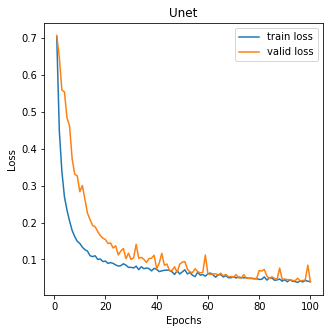

In [43]:
epochs = range(1, len(unet_hist.history['loss'])+1)
fig = plt.figure(figsize=(5,5))
plt.title('Unet')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(epochs, unet_hist.history['loss'], label='train loss')
plt.plot(epochs, unet_hist.history['val_loss'], label='valid loss')
# plt.plot(epochs, unet_hist.history['mean_io_u'], label='mean_iou')
plt.legend()
plt.show()

In [49]:
vit_unet_hist = vit_unet_model.fit(
    train_gen, 
    validation_data=valid_gen, 
    steps_per_epoch=train_steps, 
    validation_steps=valid_steps, 
    epochs=100)

Epoch 1/100
6/6 [==============================] - 2s 289ms/step - loss: 0.0612 - dice_coef: 0.2630 - mean_io_u_3: 0.4933 - val_loss: 0.2524 - val_dice_coef: 0.1456 - val_mean_io_u_3: 0.4886
Epoch 2/100
6/6 [==============================] - 2s 286ms/step - loss: 0.0678 - dice_coef: 0.2920 - mean_io_u_3: 0.4908 - val_loss: 0.3425 - val_dice_coef: 0.1288 - val_mean_io_u_3: 0.4886
Epoch 3/100
6/6 [==============================] - 2s 282ms/step - loss: 0.0633 - dice_coef: 0.2612 - mean_io_u_3: 0.4930 - val_loss: 0.2498 - val_dice_coef: 0.1626 - val_mean_io_u_3: 0.4886
Epoch 4/100
6/6 [==============================] - 2s 284ms/step - loss: 0.0604 - dice_coef: 0.1852 - mean_io_u_3: 0.4946 - val_loss: 0.1158 - val_dice_coef: 0.2464 - val_mean_io_u_3: 0.4886
Epoch 5/100
6/6 [==============================] - 2s 288ms/step - loss: 0.0599 - dice_coef: 0.2585 - mean_io_u_3: 0.4935 - val_loss: 0.1110 - val_dice_coef: 0.2627 - val_mean_io_u_3: 0.4886
Epoch 6/100
6/6 [============================

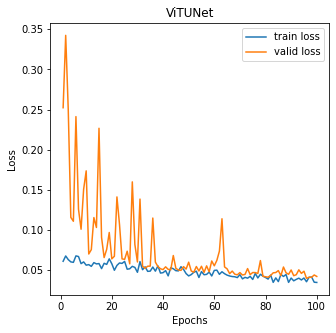

In [50]:
epochs = range(1, len(vit_unet_hist.history['loss'])+1)
fig = plt.figure(figsize=(5,5))
plt.title('ViTUNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(epochs, vit_unet_hist.history['loss'], label='train loss')
plt.plot(epochs, vit_unet_hist.history['val_loss'], label='valid loss')
# plt.plot(epochs, vit_unet_hist.history['dice_coef'], label='dice score')
# plt.plot(epochs, vit_unet_hist.history['val_dice_coef'], label='dice score')
plt.legend()
plt.show()

In [51]:
# ## Dataset for prediction UNet
# x, y = valid_gen.__getitem__(0)
# result = unet_model.predict(x)
# result =result > 0.5

In [52]:
unet_model.save_weights('UnetW.h5')
vit_unet_model.save_weights("ViTUnetW.h5")

# Inference


In [53]:
unet_inf = unet()
unet_inf.load_weights('./UnetW.h5')

In [54]:
#create inference model 
vit_unet_inf = trans_unet()
# inference_model = model
#load the weights 
vit_unet_inf.load_weights('./ViTUnetW.h5')
# inference_model.summary()

In [55]:
## Test
test_path = "./test"
test_ids = next(os.walk(test_path))[1]

# test_ids = test_ids[:10]

test_gen = DataGen(test_ids, test_path, image_size=image_size, batch_size=batch_size)

In [56]:
test_sample = random.choices(os.listdir(test_path), k=3)
print(test_sample)

['313Cop20mM2', '313Cop30mM5', '313Cop30mM3']


1/1 [==============================] - 2s 2s/step


<ipython-input-57-93172f9779f5>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 3, 1)
<ipython-input-57-93172f9779f5>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 3, 2)
<ipython-input-57-93172f9779f5>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

1/1 [==============================] - 0s 99ms/step


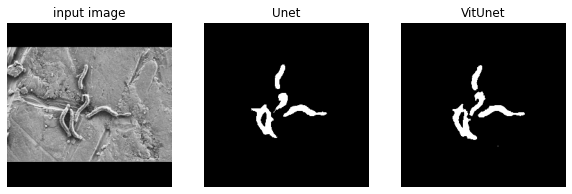

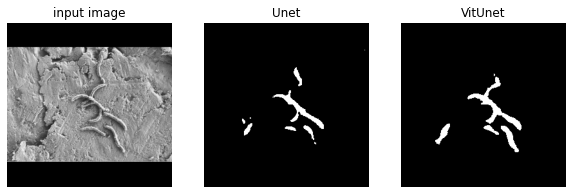

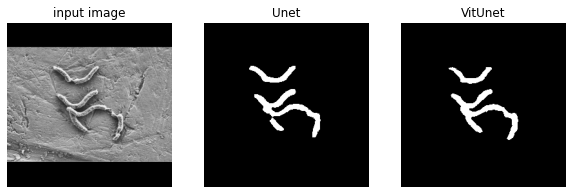

In [57]:
#Comparing test prediction
# from re import I
for i, filename  in enumerate(test_sample):
  x, y = test_gen.__getitem__(i)
  fig = plt.figure(figsize=(10,10))
  # fig.subplots_adjust(hspace=0.4, wspace=0.4)
  # fig.set_size_inches(20, 20)
  # fig.subplots(5,2)
  unet_result_test = unet_inf.predict(x) 
  unet_result_test =unet_result_test > 0.2
  vit_unet_result_test = vit_unet_inf.predict(x) 
  vit_unet_result_test = vit_unet_result_test > 0.2
  for j in range(2):
    
    ax = fig.add_subplot(1, 3, 1) 
    ax.axis('off')
    ax.set_title("input image")
    ax.imshow(np.reshape(x[j], (image_size, image_size,3)), cmap="gray")
    ax = fig.add_subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title("Unet")
    ax.imshow(np.reshape(unet_result_test[j]*255, (image_size, image_size)), cmap="gray")
    ax = fig.add_subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title("VitUnet")
    ax.imshow(np.reshape(vit_unet_result_test[j]*255, (image_size, image_size)), cmap="gray")

In [58]:
loss, diceScore, meanIou = unet_model.evaluate(test_gen)
print(f"Test loss: {round(loss * 100, 2)}%")
print(f"Test Mean IOU: {round(meanIou * 100, 2)}%")
print(f"Test Dice score: {round(diceScore * 100, 2)}%")

10/10 [==============================] - 1s 50ms/step - loss: 0.0609 - dice_coef: 0.4162 - mean_io_u_2: 0.4876
Test loss: 6.09%
Test Mean IOU: 48.76%
Test Dice score: 41.62%


In [59]:
vit_loss, vitDiceScore, vit_meanIou = vit_unet_model.evaluate(test_gen)
print(f"Test loss: {round(vit_loss * 100, 2)}%")
print(f"Test Mean IOU: {round(vit_meanIou * 100, 2)}%")
print(f"Test Dice score: {round(vitDiceScore * 100, 2)}%")

10/10 [==============================] - 1s 73ms/step - loss: 0.0579 - dice_coef: 0.4575 - mean_io_u_3: 0.4876
Test loss: 5.79%
Test Mean IOU: 48.76%
Test Dice score: 45.75%
